In [1]:
# install pygame
# pip install pygame

# install ple
# git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
# cd PyGame-Learning-Environment/
# pip install -e .

# install gym_ple
# pip install gym_ple

In [28]:
%matplotlib inline
import time
 
import gym
from gym.wrappers import Monitor
import gym_ple
import matplotlib
from matplotlib.pyplot import imshow, show
from collections import deque, namedtuple
import numpy as np
import random
from skimage import color, transform

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# env = gym.make('FlappyBird-v0').unwrapped


In [46]:
class Environment(object):
    def __init__(self, game='FlappyBird-v0', record=False, width=84, height=84, seed=0):
        self.game = gym.make(game)
        self.game.seed(seed)

        if record:
            self.game = Monitor(self.game, './video', force=True)

        self.width = width
        self.height = height

    def play_sample(self, mode: str = 'human'):
        observation = self.game.reset()

        while True:
            screen = self.game.render(mode=mode)
            if mode == 'rgb_array':
                screen = self.preprocess(screen)
            action = self.game.action_space.sample()
            observation, reward, done, info = self.game.step(action)
            if done:
                break
        self.game.close()

    def preprocess(self, screen):
        preprocessed = screen[:400, 40:]
        preprocessed = transform.resize(preprocessed, (self.height, self.width))
        preprocessed = color.rgb2gray(preprocessed)
        preprocessed = preprocessed.astype('float32') / 255.

        return preprocessed

    def init(self):
        return self.game.reset()

    def get_screen(self):
        screen = self.game.render('rgb_array')
        screen = self.preprocess(screen)
        return screen

    def step(self, action: int):
        observation, reward, done, info = self.game.step(action)
        return observation, reward, done, info

    def reset(self):
        observation = self.game.reset()
        observation = self.preprocess(observation)
        return observation
    
    def close(self):
        self.game.close()

    @property
    def action_space(self):
        return self.game.action_space.n
    
    @property
    def observation_space(self):
        return self.game.observation_space

In [47]:
env = Environment()
env.action_space, env.observation_space

(2, Box(512, 288, 3))

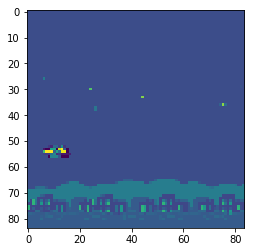

In [48]:
env.init()
env.step(1)
imshow(env.get_screen())

In [62]:
class Memory(object):
    def __init__(self, size, batch_size):
        self.buffer = deque(maxlen=size)
        self.batch_size = batch_size
        self.available = False
        self.Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))
        
    def add(self, state: np.array, action: torch.LongTensor, reward: np.array, next_state: np.array, done):
        state = torch.FloatTensor(state)
        reward = torch.FloatTensor([reward])
        if next_state is not None:
            next_state = torch.FloatTensor(next_state)
        transition = self.Transition(state=state, action=action, reward=reward, next_state=next_state, done=done)
        self.buffer.append(transition)
        
    def sample(self):
        transitions = random.sample(self.buffer, self.batch_size)
        return self.Transition(*(zip(*transitions)))

    def is_ready(self):
        if self.available:
            return True
        else:
            self.available = (len(self.buffer_size) > self.batch_size)
            return self.available

In [63]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x.view(x.size(0), -1))
        return self.fc2(x)

In [51]:
# x = torch.zeros([1,4,84,84], device=device)
# dqn = DQN().to(device)
# pred = dqn.forward(x)
# pred

In [52]:
t = np.array([1,1,1])
tt = [t,t,t]
np.array(tt).shape

(3, 3)

In [64]:
class Agent(object):
    def __init__(self):
        self.env = Environment()
        self.dqn = DQN().to(device)
        self.target = DQN().to(device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval()
        self.target_update_interval = 1000
        
        self.optimizer = optim.RMSprop(self.dqn.parameters())
        
        self.gamma = 0.9
        self.epsilon_start = 0.1
        self.epsilon_decay = 0.001
        self.epsilon_stop = 0.01
        self.batch_size = 32
        self.max_step = 1000
        
        self.memory = Memory(50000, batch_size=self.batch_size)
        
        self.transform = T.Compose([T.ToPILImage(),
                                       T.Grayscale(),
                                       T.Resize((84,84)),
                                       T.ToTensor()])
        self.frame_skipping = 4
        self.state_buffer_size = 4
        self.state_buffer = deque(maxlen=self.state_buffer_size)
    
    def get_initial_state(self):
        self.env.reset()
        
        state = self.env.get_screen()
        
        self.state_buffer = deque(maxlen=self.state_buffer_size)
        self.state_buffer.append([state for _ in range(self.state_buffer_size)])
        return np.array(self.state_buffer)
    
    def optimize(self):
        transitions = self.memory.sample()
        
        
    
        
        
        
    
#     def stack_frames(self, frame, new_episode= True):
#         processed_state = self.preprocess_frame(frame)
#         if new_episode:
#             for i in range(self.stack_size):
#                 self.stacked_frames.append(processed_state)
#         else:
#             self.stacked_frames.append(processed_state)
#         stacked = torch.cat(list(self.stacked_frames), dim=1)
#         return stacked 

    def action(self, state, steps_done):
        eps = self.epsilon_stop + (self.epsilon_start - self.epsilon_stop) * np.exp(-self.epsilon_decay * steps_done)
        if np.random.uniform() <= eps:
            with torch.no_grad():
                return self.dqn.forward(state).max(1)[1].cpu(), eps
        else:
            sample_action = self.env.game.action_space.sample()
            action = torch.IntTensor([[sample_action]])
            return action, eps
        
    def train(self):
        while True:
            self.env.reset()
            state = self.get_initial_state()
            
            steps_done = 0
            done = False
            while not done:
                action, eps = self.action(state, steps_done)
                
                for _ in range(self.frame_skipping):
                    _, reward, done, _ = self.env.step(action.item())
                    next_state = self.env.get_screen()
                    self.state_buffer.append(next_state)
                    
                    if done:
                        break
            
            
                next_state = np.array(self.state_buffer)
                
                if done:
                    self.memory.add(state, action, reward, None, done)
                else:
                    self.memory.add(state, action, reward, next_state, done)

                state = next_state
                
                if self.memory.is_ready:
                    # run optimization
                    self.optimize()
                
                steps_done += 1
                
                if steps_done % self.target_update_interval == 0:
                    self.target.load_state_dict(self.dqn.state_dict())
                
                
                
                
        
#     def create_memory(self):
#         frame = self.env.reset()
#         state = self.stack_frames(frame, True)
#         rewards = []

#         done = False
#         steps_done = 0
#         while not done or (steps_done >= self.max_step):   
#             action, eps = self.action(state, steps_done)

#             next_state, reward, done, _ = self.env.step(action.item())
            
#             rewards.append(reward)
            
#             next_state = self.stack_frames(next_state, False)

#             self.memory.add(self.transition(state, action, next_state, reward, done))

#             state = next_state
#             steps_done += 1

#             if done:
#                 next_state = torch.zeros_like(state)
#                 self.memory.add(self.transition(state, action, next_state, reward, done))
                
#                 print('Steps: {}'.format(steps_done),
#                     'Total reward: {}'.format(np.sum(rewards)),
#                       'Explore P: {:.4f}'.format(eps))
    
#     def learn(self):
#         frame = self.env.reset()
#         state = self.stack_frames(frame, True)
#         rewards = []

#         done = False
#         steps_done = 0
#         while not done or (steps_done >= self.max_step):   
#             action, eps = self.action(state, steps_done)

#             next_state, reward, done, _ = self.env.step(action.item())
            
#             rewards.append(reward)
            
#             next_state = self.stack_frames(next_state, False)

#             self.memory.add(self.transition(state, action, next_state, reward, done))

#             state = next_state
#             steps_done += 1

#             if done:
#                 next_state = torch.zeros_like(state)
#                 self.memory.add(self.transition(state, action, next_state, reward, done))
                
                
#                 print('Steps: {}'.format(steps_done),
#                     'Total reward: {}'.format(np.sum(rewards)),
#                       'Explore P: {:.4f}'.format(eps),
#                         'Loss: {}'.format(loss))
        
        
#         ###############
        
#             batch = self.memory.sample(self.batch_size)
#     #         print(batch)
#             states_mb = torch.cat([each.state for each in batch])
#             actions_mb = torch.cat([each.action for each in batch])
#             next_states_mb = torch.cat([each.next_state for each in batch])
#             rewards_mb = [each.reward for each in batch]
#             dones_mb = [each.done for each in batch]

#             target_Qs_batch = []

#              # Get Q values for next_state 
#     #         Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
#             Qs_next_state = self.dqn.forward(next_states_mb).max(1)[0].detach()
#     #         print(Qs_next_state.size(), Qs_next_state.max())

#     #         # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
#             for i in range(len(batch)):
#                 terminal = dones_mb[i]

#                 # If we are in a terminal state, only equals reward
#                 if terminal:
#                     target_Qs_batch.append(rewards_mb[i])

#                 else:
#                     target = rewards_mb[i] + self.gamma * Qs_next_state[i]
#                     target_Qs_batch.append(target)

#             Qs_targets = torch.tensor(target_Qs_batch, device=device)
#     #         print(actions_mb)
#             Qs = self.dqn.forward(states_mb).gather(1, actions_mb)
#     #         print(Qs)
#     #         print(Qs.size(), Qs_targets.size())
#             # Compute Huber loss
#             loss = F.mse_loss(Qs, Qs_targets.unsqueeze(1))
# #             print(loss.item())

#     #         # Optimize the model
#             self.optimizer.zero_grad()
#             loss.backward()
#             self.optimizer.step()
                
#     def train(self, num_episodes=10000):
#         while len(self.memory) <= self.batch_size:
#             self.create_memory()
        
#         for i in range(num_episodes):
# #             self.create_memory()
#             self.learn()
            

In [65]:
agent_dqn = Agent()
agent_dqn.train()

ValueError: Sample larger than population or is negative

In [150]:
t = torch.ones((3,3))
tt = deque([t,t,t])

In [179]:
t.unsqueeze(0).size()

torch.Size([1, 3, 3])

In [152]:
torch.cat(list(tt))

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [66]:
import random
torch.tensor([[np.random.randint(2)]], device=device, dtype=torch.long)

tensor([[0]], device='cuda:0')

In [137]:

torch.zeros_like(t)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [10]:
state = env.reset()

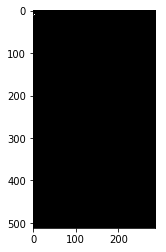

In [13]:
plt.imshow(state)

In [18]:
state = env.render(mode='rgb_array')

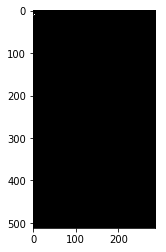

In [19]:
plt.imshow(state)

In [22]:
next_state = env.step(1)

In [ ]:
# next_state

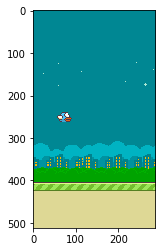

In [25]:
plt.imshow(next_state[0])

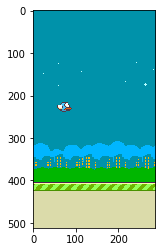

KeyboardInterrupt: 

In [14]:
env.seed(0)
agent = RandomAgent(env.action_space)

episode_count = 100
reward = 0
done = False

for i in range(episode_count):
    ob = env.reset()

    while True:
        action = agent.act(ob, reward, done)

        ob, reward, done, _ = env.step(action)
        
#         print(ob)
        clear_output(wait=True)
        plt.imshow(ob)
        show()
        time.sleep(.1)
        
        if done:
            break
        # Note there's no env.render() here. But the environment still can open window and
        # render if asked by env.monitor: it calls env.render('rgb_array') to record video.
        # Video is not recorded every episode, see capped_cubic_video_schedule for details.


In [ ]:
# references
# https://github.com/AndersonJo/dqn-pytorch/blob/master/dqn.py